In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from rasterio.features import rasterize
import rioxarray
from scipy.ndimage import binary_dilation
from shapely.geometry import box

# Introduction
#### In this notebook, I import and demonstrate some basic features of the Lidar data and levee data, from w1 and w2 directories (standing for week 1 and week 3).


# Lidar Data

In [2]:
# Importing the Lidar data (.tif files)
data_dir = "../data/raw/w2-Lidar"
tif_files = [file for file in os.listdir(data_dir) if file.endswith(".tif")]

print(len(tif_files))
tif_files[0:5]

22


['10SFH270060.tif',
 '10SFH270075.tif',
 '10SFH285015.tif',
 '10SFH285000.tif',
 '10SFH255030.tif']

In [3]:
# data from .tif files can be handled using rioxarray
images = [rioxarray.open_rasterio(os.path.join(data_dir, file)) for file in tif_files[:]]
print(len(images))

22


In [4]:
# lets select a single image:
img = images[0]
img

<xarray.DataArray (band: 1, y: 3000, x: 3000)> Size: 36MB
[9000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 24kB 6.27e+05 6.27e+05 ... 6.285e+05 6.285e+05
  * y            (y) float64 24kB 4.207e+06 4.207e+06 ... 4.206e+06 4.206e+06
    spatial_ref  int64 8B 0
Attributes: (12/16)
    AREA_OR_POINT:           Area
    LAYER_TYPE:              athematic
    STATISTICS_COVARIANCES:  44.12902708820008
    STATISTICS_MAXIMUM:      13.380000114441
    STATISTICS_MEAN:         -14.260028199235
    STATISTICS_MEDIAN:       0
    ...                      ...
    STATISTICS_STDDEV:       6.6429682438049
    _FillValue:              -3.4028235e+38
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               Layer_1
    units:                   US survey foot

In [5]:
img.shape

(1, 3000, 3000)

In [6]:
# In our case an image has 1 band (elevation)
img.band.values

array([1])

In [7]:
# The image has values which represent elevation at given pixel
img.values

array([[[-18.46, -18.47, -18.38, ...,   4.27,   4.27,   4.27],
        [-18.26, -18.29, -18.32, ...,   4.27,   4.27,   4.27],
        [-18.15, -18.17, -18.21, ...,   4.27,   4.27,   4.27],
        ...,
        [-16.92, -16.86, -16.88, ..., -14.76, -14.76, -14.76],
        [-16.75, -16.76, -16.84, ..., -14.76, -14.76, -14.76],
        [-16.85, -16.88, -16.79, ..., -14.76, -14.76, -14.76]]],
      dtype=float32)

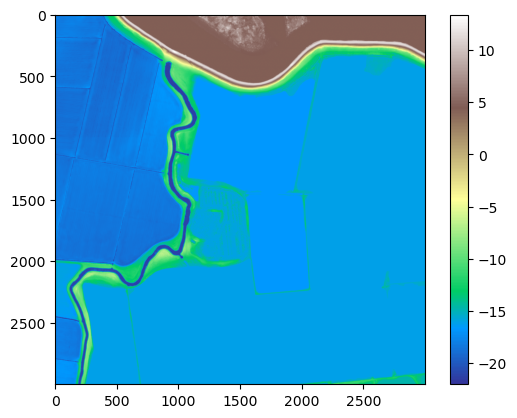

In [8]:
# Those values can be plotted as any other numpy array
# Their shape is initially (1, 3000, 3000) - we need to reshape
plt.imshow(img.values.reshape(3000, 3000), cmap='terrain')
plt.colorbar()

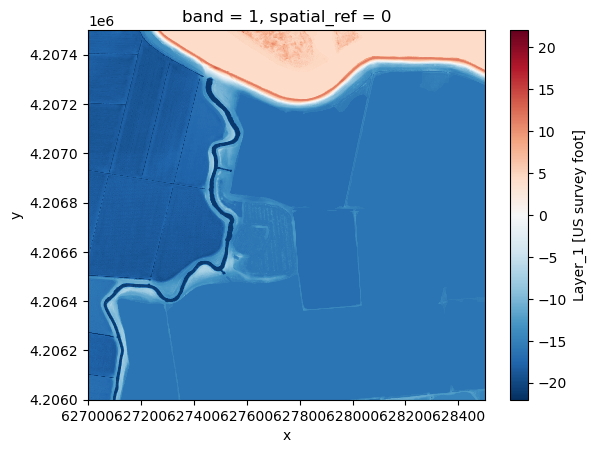

In [9]:
# Or use the built in method:
img.plot()

In [10]:
# The x axis for example
img.x.values

array([627000.25, 627000.75, 627001.25, ..., 628498.75, 628499.25,
       628499.75])

In [11]:
# Image also has its bounds
img.rio.bounds()

(627000.0, 4206000.0, 628500.0, 4207500.0)

In [12]:
# It also has Coordinate Reference System (CRS), which determines
# how points on Earth's surface are projected onto the 2D plane
print(img.rio.crs)

EPSG:3717


In [13]:
# The affine transformation matrix describes how to map pixel coordinates (row, col) 
# to geographic coordinates (x, y) using the following equation:
# x = a * col + b * row + c
# y = d * col + e * row + f

# The matrix:
# Affine(a, b, c,
#       d, e, f)

images[0].rio.transform()

Affine(0.5, 0.0, 627000.0,
       0.0, -0.5, 4207500.0)

# Levee Data

In [14]:
# The levee data we handle with geopandas
# We immediatelly convert it to the same CRS as the Lidar data
levees_file = "../data/raw/w1-Kickoff/us_levees_n38w122.gpkg"
levees_data = gpd.read_file(levees_file)
levees_data_3717 = levees_data.to_crs("EPSG:3717")
levees_data_3717[:5]

,states,floodplainManagement,districtNames,lon,leveeLengthInMiles,lat,location,leveedAreaSquareMiles,communitiesBreakdown,yearConstructed,name,geometry
0,California,FEMA Region 9,Sacramento,W122,8.867156,N38,"Oakley, Contra Costa County, California",4.624417,"Contra Costa County, CA; Oakley city, CA",NaN,Contra Costa County Levee 22,"LINESTRING Z (617775.262 4205614.726 13.096, 6..."
1,California,FEMA Region 9,Sacramento,W122,2.942670,N38,"Oakley, Contra Costa County, California",0.406329,"Oakley city, CA",NaN,Contra Costa County Levee 24,"LINESTRING Z (616876.947 4206152.549 0.0001, 6..."
2,California,FEMA Region 9,Sacramento,W122,0.166895,N38,"Pittsburg, Contra Costa County, California",0.007525,"Pittsburg city, CA",NaN,Contra Costa County Levee 217,"LINESTRING Z (601470.371 4209106.549 0.0001, 6..."
3,California,FEMA Region 9,Sacramento,W122,0.292736,N38,"Pittsburg, Contra Costa County, California",0.024989,"Pittsburg city, CA",NaN,Contra Costa County Levee 55,"LINESTRING Z (601429.725 4209117.197 0.0001, 6..."
4,California,FEMA Region 9,Sacramento,W122,4.587647,N38,"Pittsburg, Contra Costa County, California",0.650581,"Contra Costa County, CA",NaN,Contra Costa County Levee 198,"LINESTRING Z (601545.535 4209651.112 0.0001, 6..."


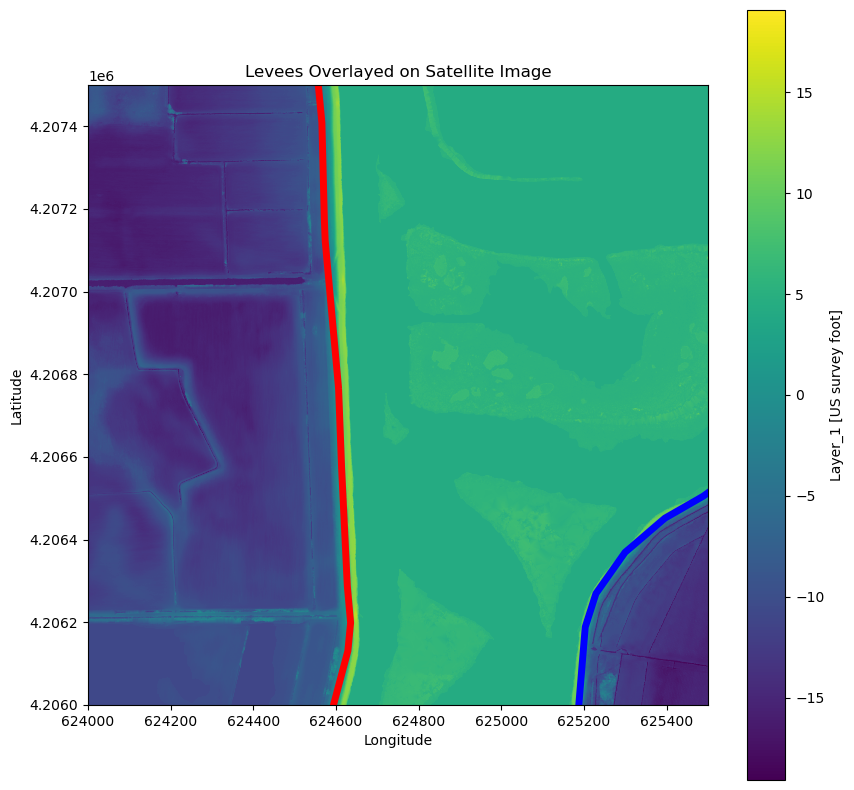

In [15]:
# I checked before, by looking at max and min coordinates of each image and levee,
# that potentially 3 levees may intersect with this image
# Here I show results of plotting that.
# As can be seen, actually only two levees intersect with this image.

fig, ax = plt.subplots(figsize=(10, 10))
images[8].plot(ax=ax, cmap="viridis")

# Overlay the levee data
levees_data_3717.iloc[9:10].plot(ax=ax, color="red", linewidth=5) 
levees_data_3717.iloc[32:33].plot(ax=ax, color="blue", linewidth=5)
levees_data_3717.iloc[59:60].plot(ax=ax, color="black", linewidth=5)

plt.title("Levees Overlayed on Satellite Image")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [16]:
# Simply a way to select a single levee
levees_data_3717.iloc[9:10]

,states,floodplainManagement,districtNames,lon,leveeLengthInMiles,lat,location,leveedAreaSquareMiles,communitiesBreakdown,yearConstructed,name,geometry
9,California,FEMA Region 9,Sacramento,W122,10.866458,N38,"Bethel Island, Contra Costa County, California",6.4413,"Contra Costa County, CA",NaN,Contra Costa County Levee 17,"LINESTRING Z (624606.155 4206765.973 0.0001, 6..."


<Axes: >

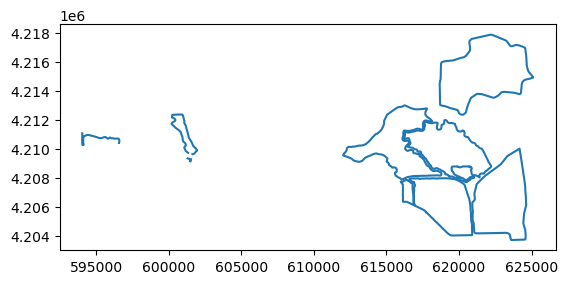

In [17]:
# Built in plotting method
levees_data_3717.iloc[0:10].plot()

In [18]:
# Selecting column as in pandas
levees_data_3717['geometry']

0      LINESTRING Z (617775.262 4205614.726 13.096, 6...
1      LINESTRING Z (616876.947 4206152.549 0.0001, 6...
2      LINESTRING Z (601470.371 4209106.549 0.0001, 6...
3      LINESTRING Z (601429.725 4209117.197 0.0001, 6...
4      LINESTRING Z (601545.535 4209651.112 0.0001, 6...
                             ...                        
225    LINESTRING Z (630034.837 4296018.828 45.796, 6...
226    LINESTRING Z (650467.065 4223708.452 54.734, 6...
227    LINESTRING Z (671196.084 4209203.816 109.984, ...
228    LINESTRING Z (642956.48 4211837.018 5.6, 64293...
229    LINESTRING Z (648575.959 4305639.516 163, 6485...
Name: geometry, Length: 230, dtype: geometry

In [19]:
# Or using .loc
levees_data_3717.loc[:, 'geometry']

0      LINESTRING Z (617775.262 4205614.726 13.096, 6...
1      LINESTRING Z (616876.947 4206152.549 0.0001, 6...
2      LINESTRING Z (601470.371 4209106.549 0.0001, 6...
3      LINESTRING Z (601429.725 4209117.197 0.0001, 6...
4      LINESTRING Z (601545.535 4209651.112 0.0001, 6...
                             ...                        
225    LINESTRING Z (630034.837 4296018.828 45.796, 6...
226    LINESTRING Z (650467.065 4223708.452 54.734, 6...
227    LINESTRING Z (671196.084 4209203.816 109.984, ...
228    LINESTRING Z (642956.48 4211837.018 5.6, 64293...
229    LINESTRING Z (648575.959 4305639.516 163, 6485...
Name: geometry, Length: 230, dtype: geometry

In [20]:
# Lets define a single levee
lve = levees_data_3717.iloc[9:10]

# Its geometry is a linestring
lve['geometry'].shape

(1,)

True


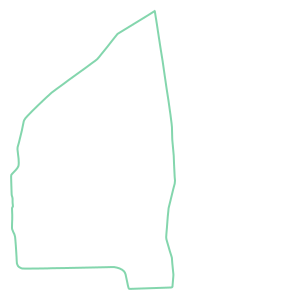

In [21]:
# LineString is from the shapely.geometry
from shapely.geometry import LineString
print(isinstance(levees_data_3717.loc[32].geometry, LineString))

# We can plot its shape
lve['geometry'].values[0]

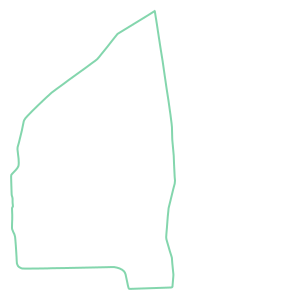

In [22]:
# Or using .iloc alternatively
lve['geometry'].iloc[0]

In [23]:
# Length of the levee, .iloc would also work here
lve['geometry'].values[0].length

17484.172037556462

In [24]:
# We can take the coordinates of the shape using numpy array
# The first is x coordinate, the second is y coordinate
# Third is not important for us
print(np.array(lve.geometry.values[0].coords).shape)

# Output first 10 rows
np.array(lve.geometry.values[0].coords)[:10]

(135, 3)


array([[6.24606155e+05, 4.20676597e+06, 1.30833389e-04],
       [6.24613426e+05, 4.20657481e+06, 1.30833389e-04],
       [6.24627316e+05, 4.20628774e+06, 1.30833389e-04],
       [6.24632838e+05, 4.20622609e+06, 1.30833389e-04],
       [6.24635255e+05, 4.20619910e+06, 1.30833389e-04],
       [6.24628644e+05, 4.20613098e+06, 1.30833389e-04],
       [6.24594903e+05, 4.20600397e+06, 1.30833389e-04],
       [6.24524791e+05, 4.20571492e+06, 1.30833389e-04],
       [6.24490392e+05, 4.20557667e+06, 1.30833389e-04],
       [6.24475842e+05, 4.20543049e+06, 1.30833389e-04]])

In [25]:
# Or also using .xy
lve.geometry.values[0].xy

(array('d', [624606.1553743312, 624613.4263309833, 624627.3158344745, 624632.8375473908, 624635.2548437009, 624628.6437538828, 624594.9031386732, 624524.7906978285, 624490.39230381, 624475.8421040805, 624469.8861895589, 624452.6904206434, 624439.462068323, 624434.832629904, 624439.4666853053, 624447.4057609508, 624515.535022768, 624553.8983791936, 624564.4817680838, 624573.7421208624, 624598.8800330521, 624597.5557983019, 624587.6695964106, 624577.092314158, 624567.1714783222, 624548.6467471804, 624417.678983602, 624184.1798171921, 623887.1815490569, 623660.3068451127, 623608.7111237212, 623591.5090011596, 623581.5884109697, 623566.3787952254, 623548.5166755201, 623513.4217081052, 623496.8904577122, 623475.0650817452, 623434.7070964826, 623378.4909164608, 623316.3103239555, 623254.7931690098, 623178.0644157629, 623080.1684630773, 622496.0975609828, 622170.6584631217, 621847.8694620256, 621738.0634457802, 621480.0972158146, 621263.1365112656, 621176.488245357, 621150.0274944258, 621103.